# ML Model Trainer for Polymer Composite Properties

In [18]:
# import and download polymer_composite_dataset.csv

from google.colab import files
import pandas as pd

# import polymer_composite_dataset.csv from my google colab files

uploaded = files.upload()

try:
    df = pd.read_csv('polymer_composite_dataset.csv')
    print("File 'polymer_composite_dataset.csv' loaded successfully.")
    print(df.head())
except KeyError:
    print("Error: 'polymer_composite_dataset.csv' not found after upload.")
    print("Please ensure the file was uploaded correctly and the name is 'polymer_composite_dataset.csv'.")

Saving polymer_composite_dataset.csv to polymer_composite_dataset (5).csv
File 'polymer_composite_dataset.csv' loaded successfully.
  Polymer_Matrix   Filler_Type  Filler_Ratio_wt%  Matrix_Ratio_wt%  \
0       Phenolic   Flax Fibers         29.932924         70.067076   
1       Phenolic   Hemp Fibers         14.561457         85.438543   
2      Polyester    Wood Flour         47.110088         52.889912   
3       Phenolic  Coconut Coir          1.565665         98.434335   
4       Phenolic   Hemp Fibers         14.813675         85.186325   

   Curing_Temperature_C  Curing_Time_hours  Pressure_MPa  \
0             78.722237           5.431879      0.675028   
1            133.422347           5.068865      2.992232   
2            127.594586          10.479163      0.258066   
3            161.074173          11.894591      4.011987   
4             79.832033           2.344001      4.291675   

   Particle_Size_microns  Density_g_cm3  Tensile_Strength_MPa  \
0             434.426

In [19]:
pip install joblib

Loading dataset...
Preprocessing data...
Training model...

MODEL PERFORMANCE METRICS

Training Metrics:
Tensile_Strength_MPa:
  R² Score: 0.9598
  RMSE: 5.5941
  MAE: 3.9859
Flexural_Strength_MPa:
  R² Score: 0.9601
  RMSE: 8.9936
  MAE: 6.6709
Impact_Strength_J_m:
  R² Score: 0.9689
  RMSE: 1.5513
  MAE: 1.0815
Thermal_Conductivity_W_mK:
  R² Score: 0.9382
  RMSE: 0.0183
  MAE: 0.0129
Glass_Transition_Temp_C:
  R² Score: 0.7536
  RMSE: 21.7591
  MAE: 18.5636
Thermal_Expansion_ppm_C:
  R² Score: 0.7574
  RMSE: 8.5330
  MAE: 7.2050
Electrical_Resistivity_Ohm_m:
  R² Score: 0.9991
  RMSE: 0.0315
  MAE: 0.0242
Dielectric_Constant:
  R² Score: 0.7525
  RMSE: 0.7944
  MAE: 0.6755
Dielectric_Strength_kV_mm:
  R² Score: 0.7532
  RMSE: 4.7335
  MAE: 3.9166

Overall Training R² Score: 0.8714

Test Metrics:
Tensile_Strength_MPa:
  R² Score: 0.8397
  RMSE: 12.4875
  MAE: 9.1605
Flexural_Strength_MPa:
  R² Score: 0.8134
  RMSE: 22.0794
  MAE: 17.0226
Impact_Strength_J_m:
  R² Score: 0.8091
  RMSE

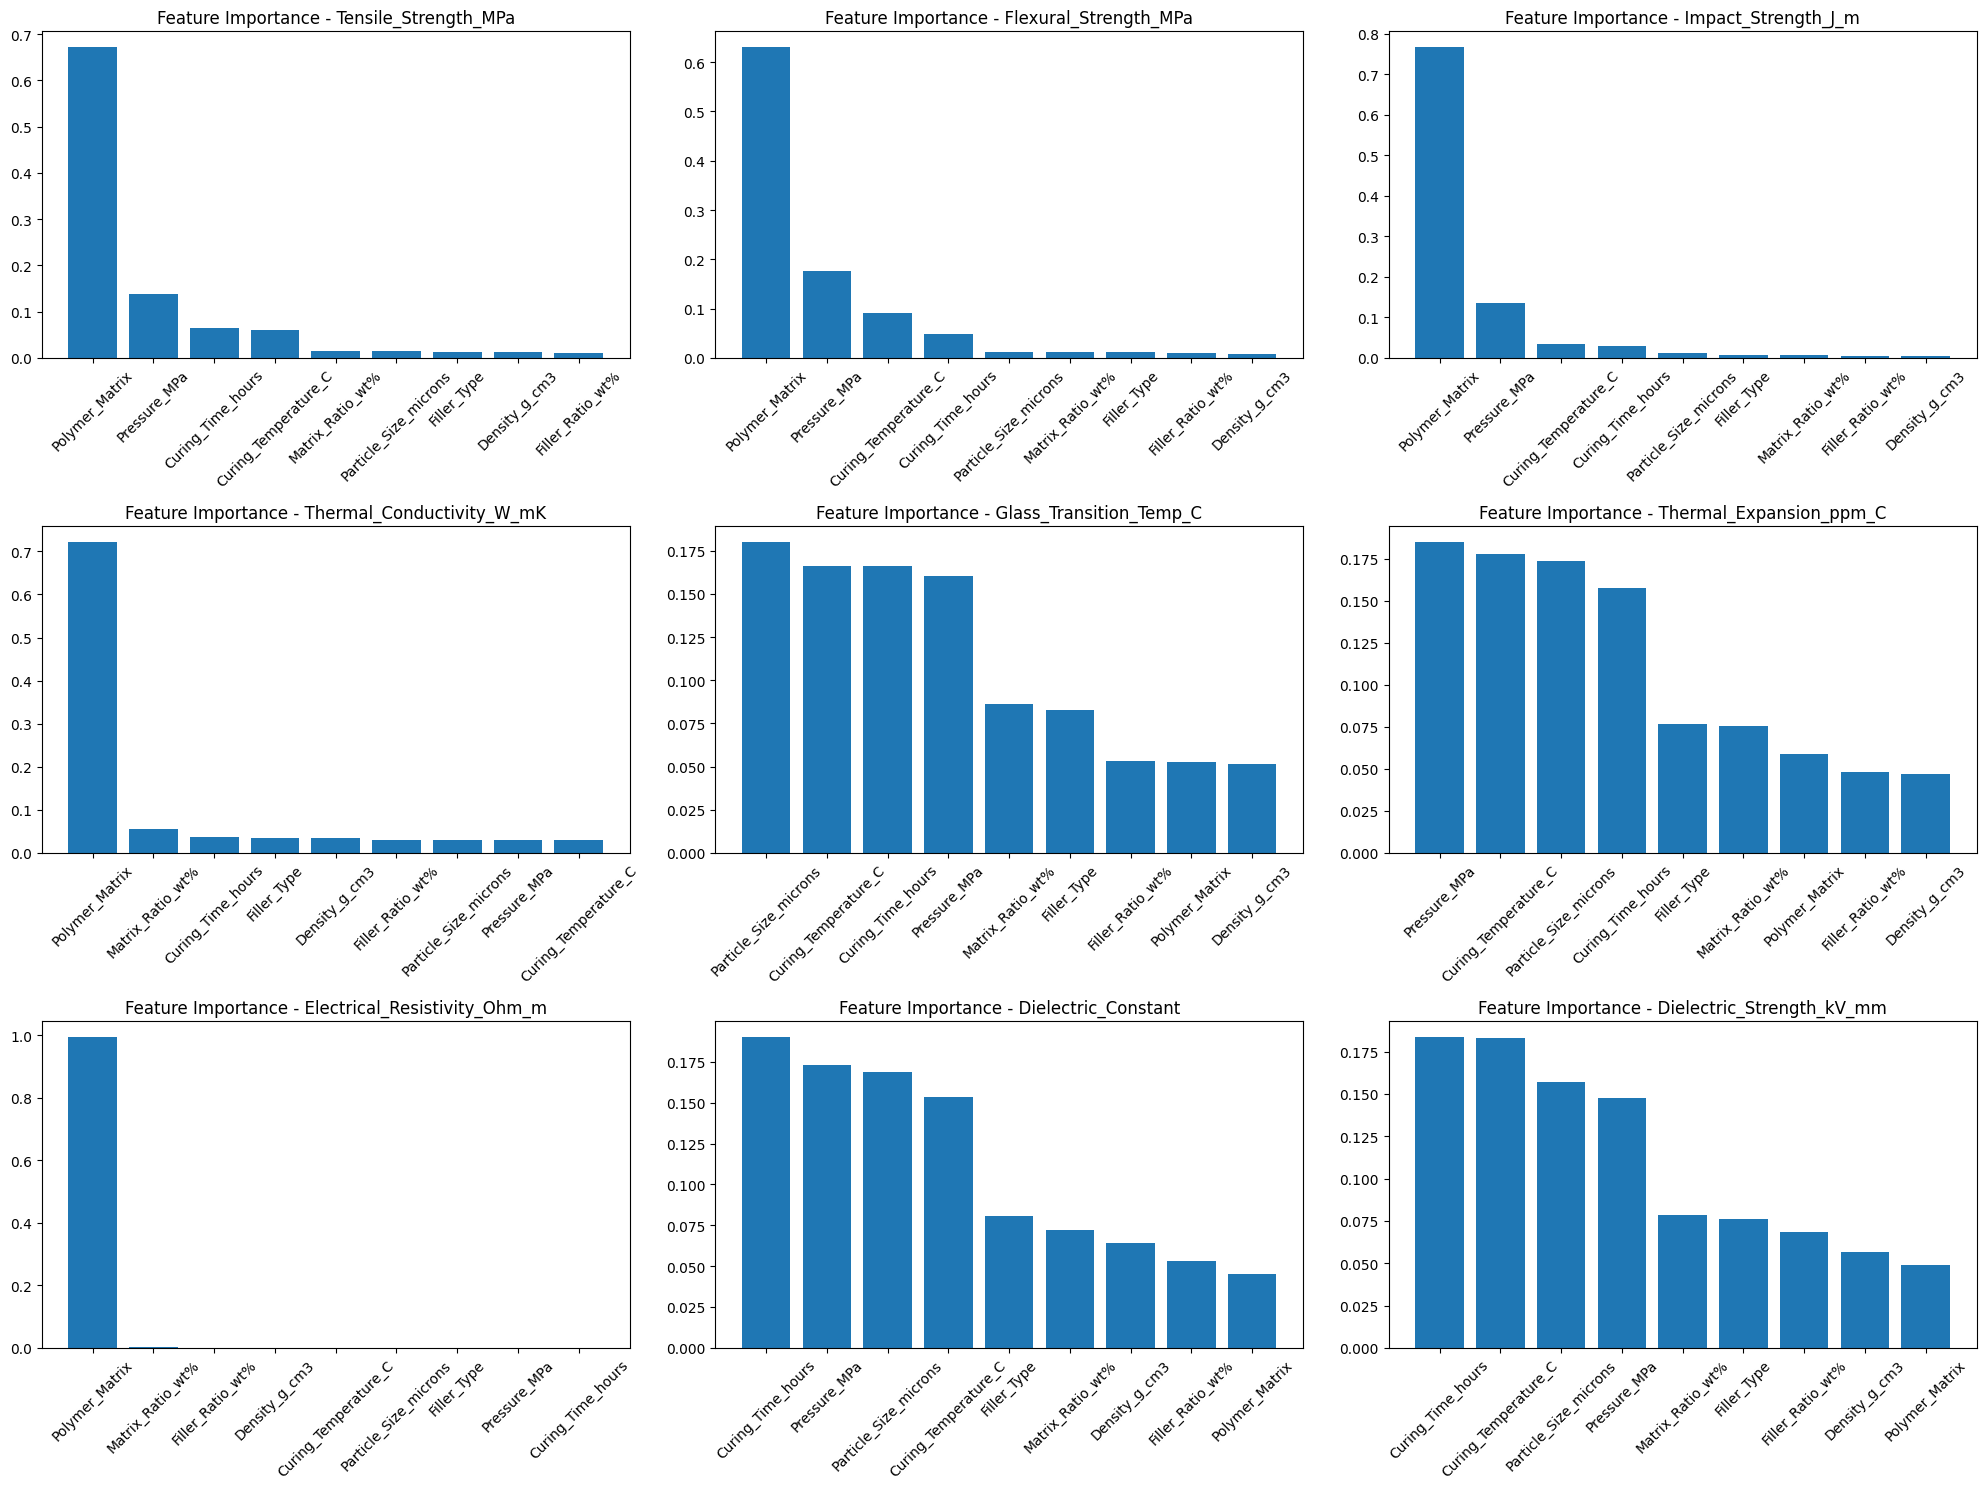

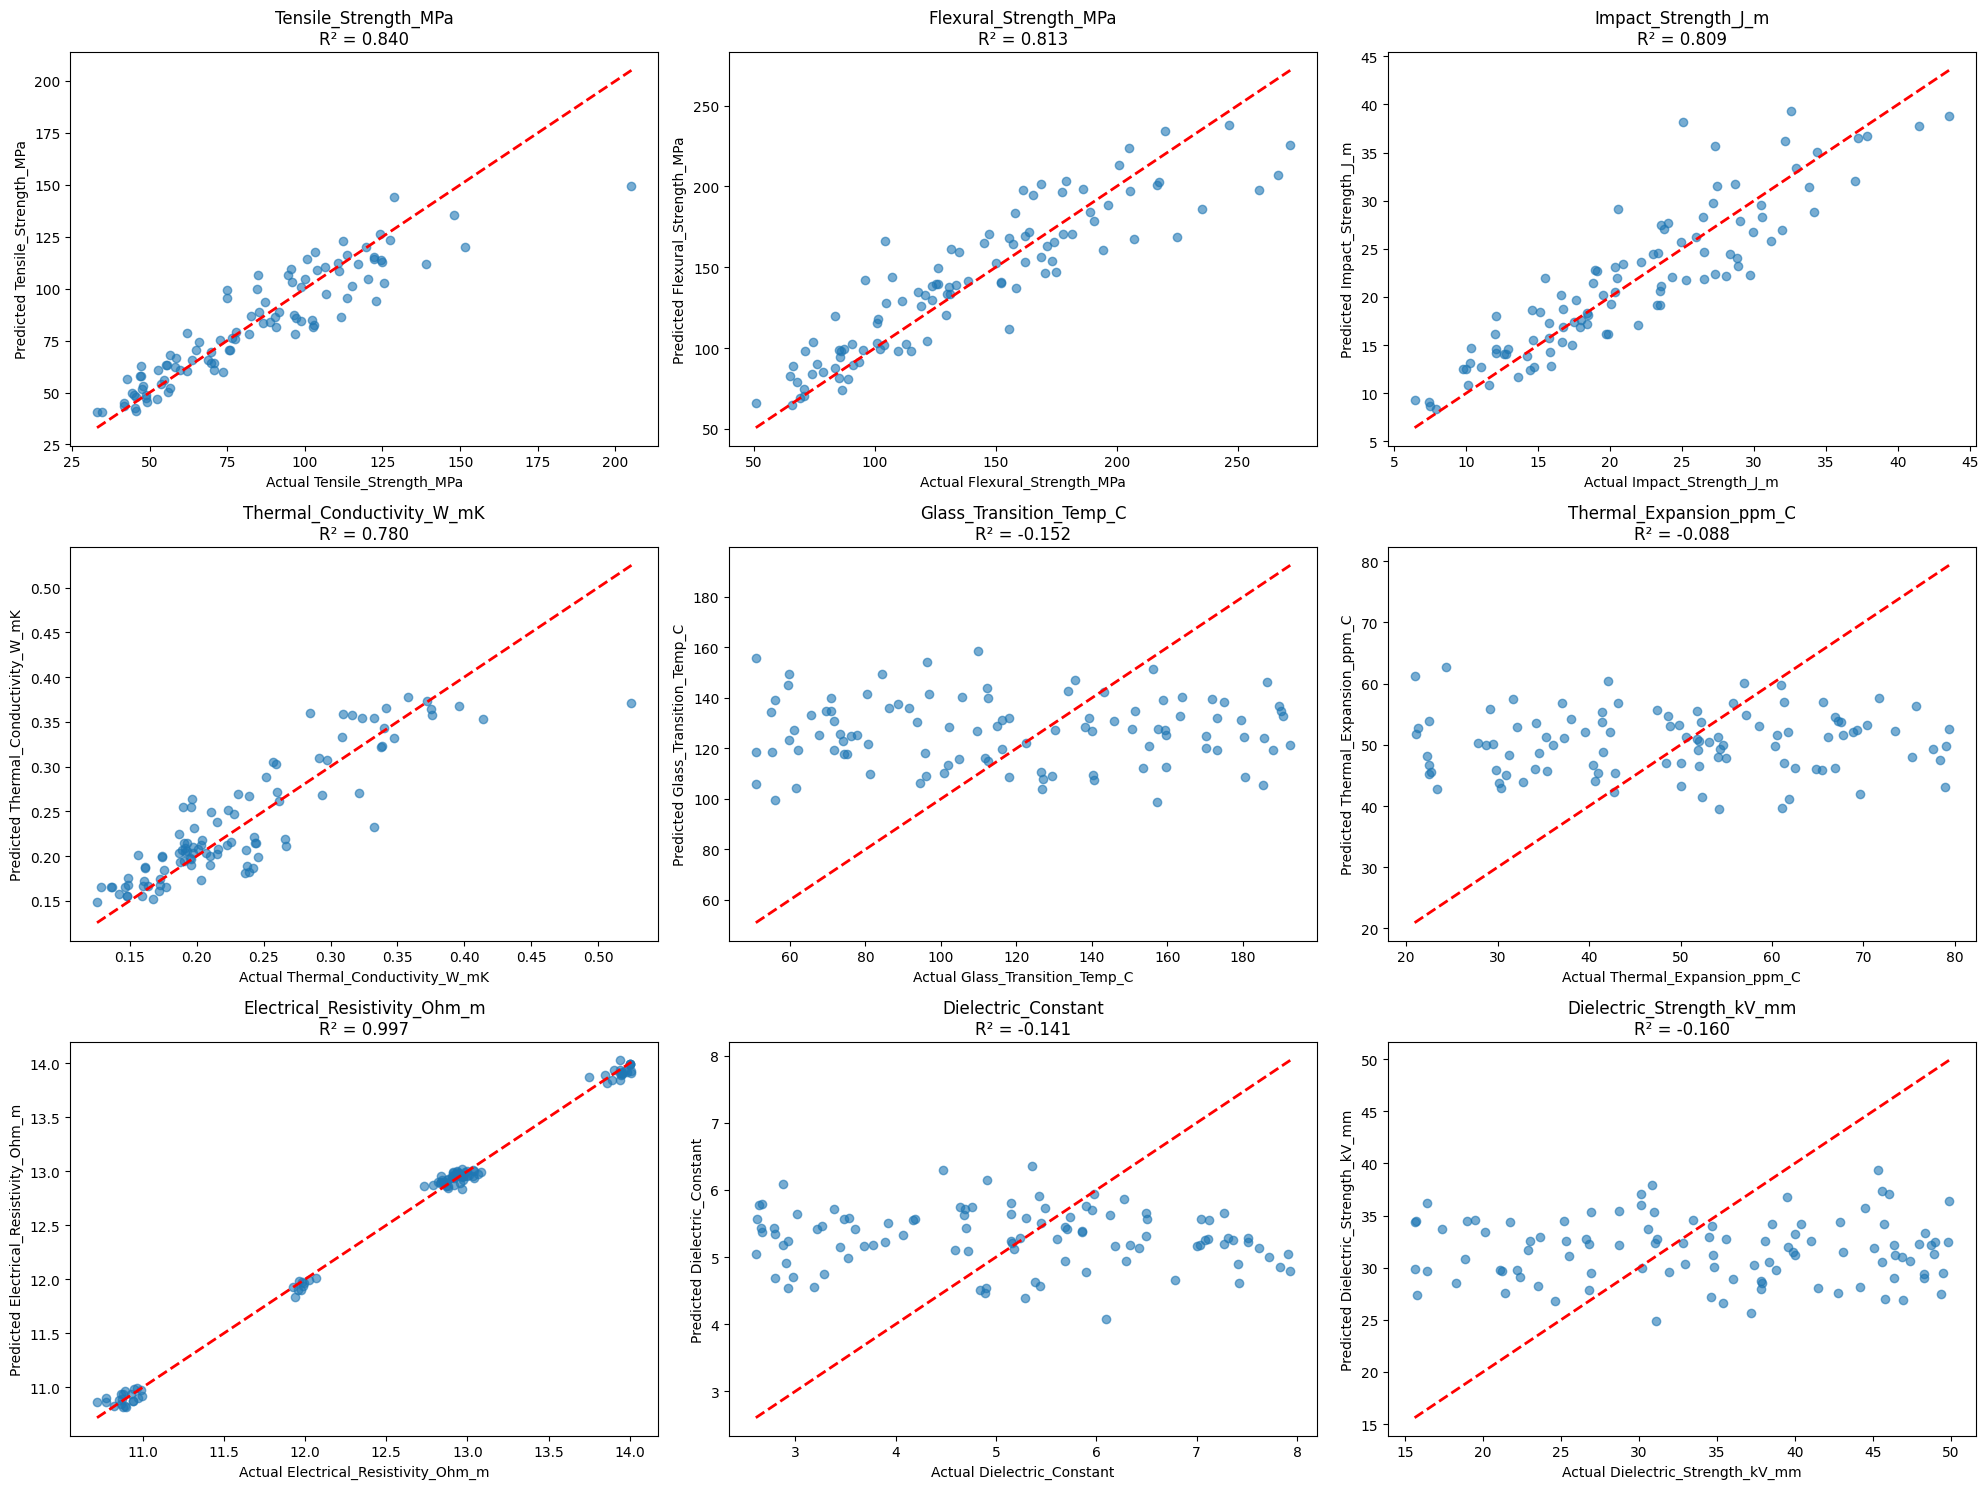

Model saved to polymer_composite_model.pkl

EXAMPLE PREDICTION
Input:
- Polymer Matrix: Epoxy
- Filler Type: Bovine Bone Particles
- Filler Ratio: 30.0 wt%
- Curing Temperature: 120.0°C
- Curing Time: 8.0 hours
- Pressure: 2.0 MPa
- Particle Size: 100.0 μm
- Density: 1.5 g/cm³

Predicted Properties:
- Tensile_Strength_MPa: 88.01
- Flexural_Strength_MPa: 138.83
- Impact_Strength_J_m: 15.99
- Thermal_Conductivity_W_mK: 0.23
- Glass_Transition_Temp_C: 146.09
- Thermal_Expansion_ppm_C: 47.29
- Electrical_Resistivity_Ohm_m: 7.82e+13
- Dielectric_Constant: 5.49
- Dielectric_Strength_kV_mm: 31.43

Model training completed successfully!


In [20]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class PolymerCompositePredictor:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.label_encoders = {}
        self.feature_names = None
        self.target_names = None

    def preprocess_data(self, df):
        """
        Preprocess the dataset for machine learning
        """
        # Make a copy to avoid modifying original data
        data = df.copy()

        # Define categorical and numerical features
        categorical_features = ['Polymer_Matrix', 'Filler_Type']
        numerical_features = ['Filler_Ratio_wt%', 'Matrix_Ratio_wt%', 'Curing_Temperature_C',
                             'Curing_Time_hours', 'Pressure_MPa', 'Particle_Size_microns', 'Density_g_cm3']

        # Define target variables (properties to predict)
        target_features = ['Tensile_Strength_MPa', 'Flexural_Strength_MPa', 'Impact_Strength_J_m',
                          'Thermal_Conductivity_W_mK', 'Glass_Transition_Temp_C', 'Thermal_Expansion_ppm_C',
                          'Electrical_Resistivity_Ohm_m', 'Dielectric_Constant', 'Dielectric_Strength_kV_mm']

        # Encode categorical variables
        for feature in categorical_features:
            if feature not in self.label_encoders:
                self.label_encoders[feature] = LabelEncoder()
                data[feature] = self.label_encoders[feature].fit_transform(data[feature])
            else:
                data[feature] = self.label_encoders[feature].transform(data[feature])

        # Prepare features and targets
        X = data[categorical_features + numerical_features]
        y = data[target_features]

        # Handle log transformation for electrical resistivity
        y_processed = y.copy()
        y_processed['Electrical_Resistivity_Ohm_m'] = np.log10(y_processed['Electrical_Resistivity_Ohm_m'])

        self.feature_names = X.columns.tolist()
        self.target_names = y_processed.columns.tolist()

        return X, y_processed

    def train_model(self, X, y):
        """
        Train the multi-output regression model
        """
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale the features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Create and train the model
        base_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )

        self.model = MultiOutputRegressor(base_model)
        self.model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred_train = self.model.predict(X_train_scaled)
        y_pred_test = self.model.predict(X_test_scaled)

        # Calculate metrics
        train_metrics = self.calculate_metrics(y_train, y_pred_train)
        test_metrics = self.calculate_metrics(y_test, y_pred_test)

        return (X_train, X_test, y_train, y_test,
                y_pred_train, y_pred_test,
                train_metrics, test_metrics)

    def calculate_metrics(self, y_true, y_pred):
        """
        Calculate regression metrics for multi-output model
        """
        metrics = {}

        for i, target in enumerate(self.target_names):
            metrics[target] = {
                'R2': r2_score(y_true.iloc[:, i], y_pred[:, i]),
                'RMSE': np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i])),
                'MAE': mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
            }

        # Overall metrics
        metrics['Overall'] = {
            'R2': r2_score(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred)
        }

        return metrics

    def predict(self, X):
        """
        Make predictions on new data
        """
        if self.model is None or self.scaler is None:
            raise ValueError("Model must be trained first")

        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)

        # Convert electrical resistivity back from log scale
        predictions_df = pd.DataFrame(predictions, columns=self.target_names)
        predictions_df['Electrical_Resistivity_Ohm_m'] = 10 ** predictions_df['Electrical_Resistivity_Ohm_m']

        return predictions_df

    def get_feature_importance(self):
        """
        Get feature importance for each target variable
        """
        if self.model is None:
            raise ValueError("Model must be trained first")

        importance_dict = {}

        for i, target in enumerate(self.target_names):
            importance_dict[target] = dict(zip(
                self.feature_names,
                self.model.estimators_[i].feature_importances_
            ))

        return importance_dict

    def save_model(self, filepath):
        """
        Save the trained model and preprocessors
        """
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'label_encoders': self.label_encoders,
            'feature_names': self.feature_names,
            'target_names': self.target_names
        }
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """
        Load a trained model and preprocessors
        """
        model_data = joblib.load(filepath)
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.label_encoders = model_data['label_encoders']
        self.feature_names = model_data['feature_names']
        self.target_names = model_data['target_names']
        print(f"Model loaded from {filepath}")

# Main training script
def main():
    # Load the dataset
    print("Loading dataset...")
    df = pd.read_csv('polymer_composite_dataset.csv')

    # Initialize the predictor
    predictor = PolymerCompositePredictor()

    # Preprocess the data
    print("Preprocessing data...")
    X, y = predictor.preprocess_data(df)

    # Train the model
    print("Training model...")
    (X_train, X_test, y_train, y_test,
     y_pred_train, y_pred_test,
     train_metrics, test_metrics) = predictor.train_model(X, y)

    # Print results
    print("\n" + "="*50)
    print("MODEL PERFORMANCE METRICS")
    print("="*50)

    print("\nTraining Metrics:")
    for target, metrics in train_metrics.items():
        if target != 'Overall':
            print(f"{target}:")
            print(f"  R² Score: {metrics['R2']:.4f}")
            print(f"  RMSE: {metrics['RMSE']:.4f}")
            print(f"  MAE: {metrics['MAE']:.4f}")

    print(f"\nOverall Training R² Score: {train_metrics['Overall']['R2']:.4f}")

    print("\nTest Metrics:")
    for target, metrics in test_metrics.items():
        if target != 'Overall':
            print(f"{target}:")
            print(f"  R² Score: {metrics['R2']:.4f}")
            print(f"  RMSE: {metrics['RMSE']:.4f}")
            print(f"  MAE: {metrics['MAE']:.4f}")

    print(f"\nOverall Test R² Score: {test_metrics['Overall']['R2']:.4f}")

    # Feature importance
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE")
    print("="*50)

    feature_importance = predictor.get_feature_importance()

    # Create feature importance visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()

    for i, (target, importance) in enumerate(feature_importance.items()):
        if i < 9:  # We have 9 targets
            features = list(importance.keys())
            importances = list(importance.values())

            # Sort by importance
            sorted_idx = np.argsort(importances)[::-1]

            axes[i].bar(range(len(features)), [importances[j] for j in sorted_idx])
            axes[i].set_title(f'Feature Importance - {target}')
            axes[i].set_xticks(range(len(features)))
            axes[i].set_xticklabels([features[j] for j in sorted_idx], rotation=45)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create prediction vs actual plots
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()

    for i, target in enumerate(predictor.target_names):
        if i < 9:
            y_true = y_test.iloc[:, i]
            y_pred = y_pred_test[:, i]

            axes[i].scatter(y_true, y_pred, alpha=0.6)
            axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            axes[i].set_xlabel(f'Actual {target}')
            axes[i].set_ylabel(f'Predicted {target}')
            axes[i].set_title(f'{target}\nR² = {test_metrics[target]["R2"]:.3f}')

    plt.tight_layout()
    plt.savefig('prediction_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save the model
    predictor.save_model('polymer_composite_model.pkl')

    # Example prediction
    print("\n" + "="*50)
    print("EXAMPLE PREDICTION")
    print("="*50)

    # Create example input
    example_input = pd.DataFrame({
        'Polymer_Matrix': ['Epoxy'],
        'Filler_Type': ['Bovine Bone Particles'],
        'Filler_Ratio_wt%': [30.0],
        'Matrix_Ratio_wt%': [70.0],
        'Curing_Temperature_C': [120.0],
        'Curing_Time_hours': [8.0],
        'Pressure_MPa': [2.0],
        'Particle_Size_microns': [100.0],
        'Density_g_cm3': [1.5]
    })

    # Encode categorical variables for prediction
    for feature in ['Polymer_Matrix', 'Filler_Type']:
        example_input[feature] = predictor.label_encoders[feature].transform(example_input[feature])

    # Make prediction
    prediction = predictor.predict(example_input)

    print("Input:")
    print("- Polymer Matrix: Epoxy")
    print("- Filler Type: Bovine Bone Particles")
    print("- Filler Ratio: 30.0 wt%")
    print("- Curing Temperature: 120.0°C")
    print("- Curing Time: 8.0 hours")
    print("- Pressure: 2.0 MPa")
    print("- Particle Size: 100.0 μm")
    print("- Density: 1.5 g/cm³")

    print("\nPredicted Properties:")
    for target, value in zip(predictor.target_names, prediction.iloc[0]):
        if target == 'Electrical_Resistivity_Ohm_m':
            print(f"- {target}: {value:.2e}")
        else:
            print(f"- {target}: {value:.2f}")

    return predictor

if __name__ == "__main__":
    predictor = main()
    print("\nModel training completed successfully!")

In [21]:
# prompt: download the model pkl

from google.colab import files

files.download('polymer_composite_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>